## Modelo de regresión lineal

Lectura y preparación de datos

In [113]:
import pandas as pd
compras= pd.read_excel(r'C:\Codeproject\Analisis Inventario\VisualStudio_ETL\H_compras_filtrada.xlsx')
ventas = pd.read_excel(r'C:\Codeproject\Analisis Inventario\VisualStudio_ETL\H_ventas.xlsx')

Análisis Exploratorio de Datos (EDA)

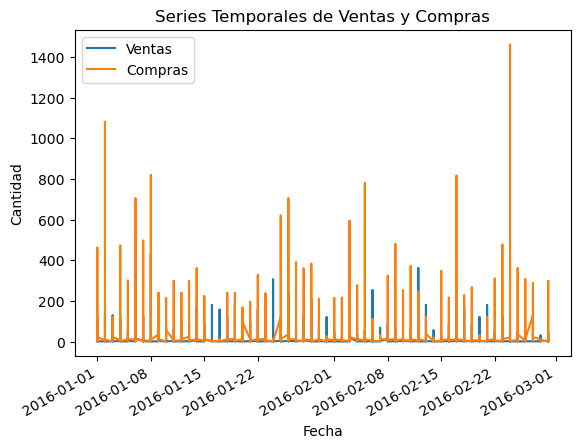

In [114]:
import matplotlib.pyplot as plt
ventas['Fecha venta'] = pd.to_datetime(ventas['Fecha venta'], format='%d/%m/%Y')
compras['Fecha llegada'] = pd.to_datetime(compras['Fecha llegada'], format='%d/%m/%Y')

# Series temporales de ventas y compras
ventas.set_index('Fecha venta')['Cantidad ventas'].plot(label='Ventas')
compras.set_index('Fecha llegada')['Cantidad'].plot(label='Compras')
plt.legend()
plt.title('Series Temporales de Ventas y Compras')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.show()

Generación de características

In [115]:
# Convertir las columnas de fecha a formato datetime
ventas['Fecha venta'] = pd.to_datetime(ventas['Fecha venta'], format='%d/%m/%Y')
compras['Fecha llegada'] = pd.to_datetime(compras['Fecha llegada'], format='%d/%m/%Y')

# Crear características adicionales
ventas['semana'] = ventas['Fecha venta'].dt.isocalendar().week
compras['semana'] = compras['Fecha llegada'].dt.isocalendar().week

# Calcular ventas y compras semanales
ventas_semanales = ventas.groupby('semana')['Cantidad ventas'].sum().reset_index()
compras_semanales = compras.groupby('semana')['Cantidad'].sum().reset_index()

# Unir datasets de ventas y compras semanales
data = pd.merge(ventas_semanales, compras_semanales, on='semana', how='left', suffixes=('_ventas', '_compras'))
data.fillna(0, inplace=True)
data

,semana,Cantidad ventas,Cantidad
0,1,438547,638267
1,2,480731,410961
2,3,495151,427539
3,4,584468,612204
4,5,60548,544685
5,6,67005,454194
6,7,62073,466803
7,8,60679,646038
8,9,5905,70708
9,53,196062,143342


Selección y Entrenamiento del Modelo

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Datos de entrenamiento y prueba
X = data[['semana', 'Cantidad']]
y = data['Cantidad ventas']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento del modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Predicción
y_pred = model.predict(X_test)

# Evaluación
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 224483.14669864657
RMSE: 224578.26068485063


## Modelos Avanzado --> Random forest

In [117]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Nuevas características (ejemplo: mes, día de la semana)
data['mes'] = data['semana'] // 4  # Suponiendo 4 semanas por mes
data['dia_semana'] = data['semana'] % 7  # Suponiendo semana de 7 días

# Datos de entrenamiento y prueba con nuevas características
X = data[['semana', 'Cantidad', 'mes', 'dia_semana']]
y = data['Cantidad ventas']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo más avanzado: Random Forest
rf = RandomForestRegressor(random_state=42)

# Búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Nueva evaluación
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)


print(f'Nuevo MAE: {mae}')
print(f'Nuevo RMSE: {rmse}')


# Coeficiente de determinación en conjunto de entrenamiento
train_r2 = best_rf.score(X_train, y_train)

# Coeficiente de determinación en conjunto de prueba
test_r2 = best_rf.score(X_test, y_test)

print("Coeficiente de determinación en entrenamiento:", train_r2)
print("Coeficiente de determinación en prueba:", test_r2)

Nuevo MAE: 60981.17333333334
Nuevo RMSE: 69531.44789192114
Coeficiente de determinación en entrenamiento: 0.8893380710565495
Coeficiente de determinación en prueba: 0.914226416575083


## Uso de modelo de Series Temporales

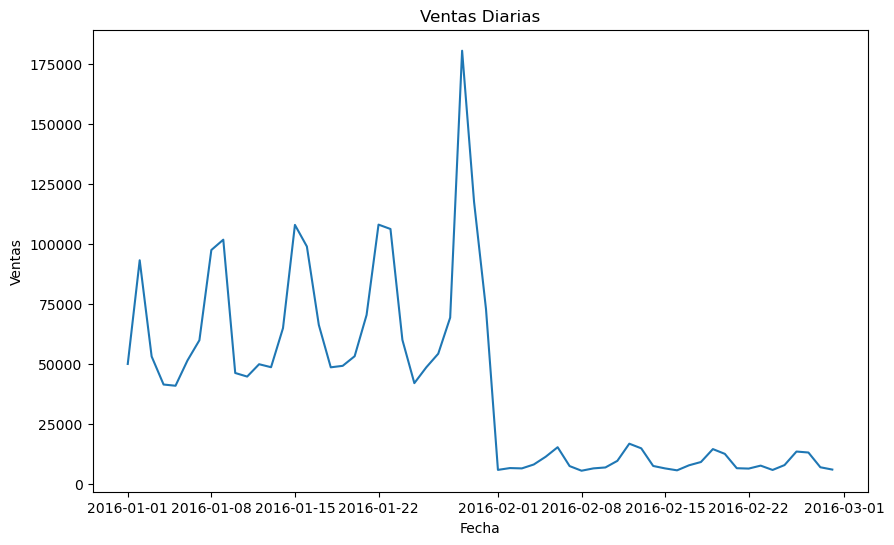

Estadística ADF: -0.6876738867860273
Valor p: 0.8499164973101778
Valores críticos: {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}
Resultados de la prueba:
La serie temporal no es estacionaria


In [118]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Leer los datos de ventas desde un archivo Excel
ventas = pd.read_excel(r'C:\Codeproject\Analisis Inventario\VisualStudio_ETL\H_ventas.xlsx')
# Convertir la columna 'Fecha venta' a datetime con dayfirst=True
ventas['Fecha venta'] = pd.to_datetime(ventas['Fecha venta'], dayfirst=True)

# Preparar los datos de series temporales
ventas.set_index('Fecha venta', inplace=True)
ventas_ts = ventas['Cantidad ventas'].resample('D').sum() 

# Visualización de la serie temporal
plt.figure(figsize=(10, 6))
plt.plot(ventas_ts)
plt.title('Ventas Diarias')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.show()

# Prueba de Dickey-Fuller aumentada (ADF test)
resultado_adf = adfuller(ventas_ts)

# Imprimir resultados
print('Estadística ADF:', resultado_adf[0])
print('Valor p:', resultado_adf[1])
print('Valores críticos:', resultado_adf[4])
print('Resultados de la prueba:')
print('La serie temporal es estacionaria' if resultado_adf[1] < 0.05 else 'La serie temporal no es estacionaria')

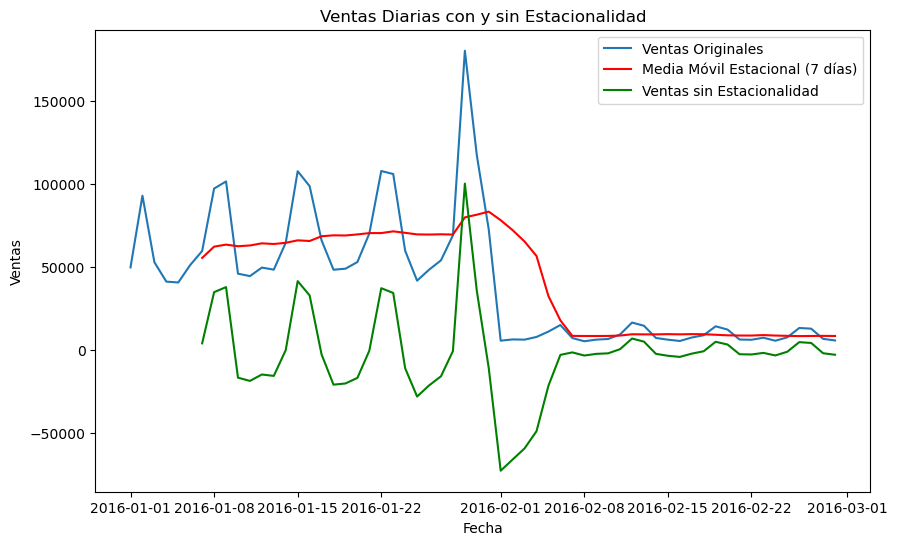

In [119]:
import pandas as pd
import matplotlib.pyplot as plt

# Leer los datos de ventas desde un archivo Excel
ventas = pd.read_excel(r'C:\Codeproject\Analisis Inventario\VisualStudio_ETL\H_ventas.xlsx')

# Convertir la columna 'Fecha venta' a datetime con dayfirst=True
ventas['Fecha venta'] = pd.to_datetime(ventas['Fecha venta'], dayfirst=True)

# Preparar los datos de series temporales
ventas.set_index('Fecha venta', inplace=True)
ventas_ts = ventas['Cantidad ventas'].resample('D').sum() 

# Calcular la media móvil estacional con una ventana de 7 días
media_movil_estacional = ventas_ts.rolling(window=7).mean()

# Eliminar la media móvil estacional
ventas_sin_estacionalidad = ventas_ts - media_movil_estacional

# Visualizar la serie temporal original y la serie sin estacionalidad
plt.figure(figsize=(10, 6))
plt.plot(ventas_ts, label='Ventas Originales')
plt.plot(media_movil_estacional, label='Media Móvil Estacional (7 días)', color='red')
plt.plot(ventas_sin_estacionalidad, label='Ventas sin Estacionalidad', color='green')
plt.title('Ventas Diarias con y sin Estacionalidad')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

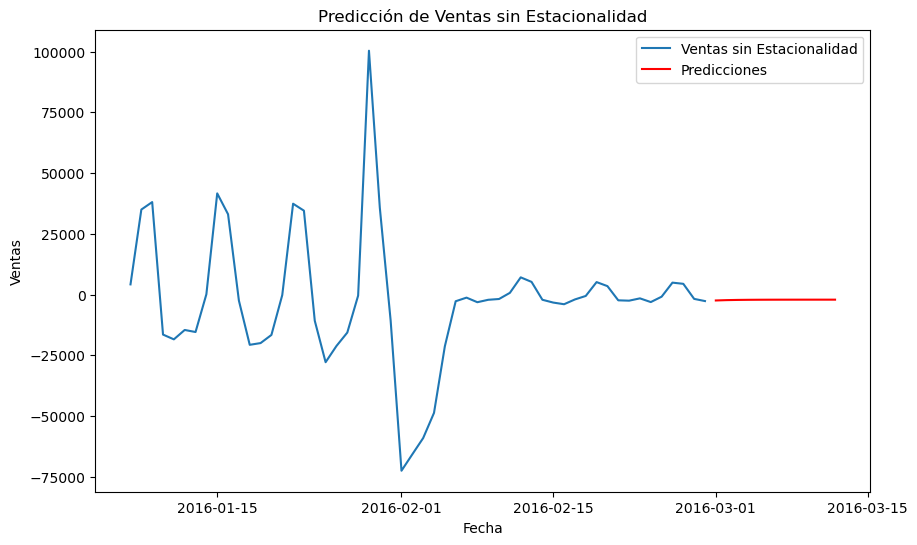

In [120]:
from statsmodels.tsa.arima.model import ARIMA

# Entrenar modelo ARIMA en la serie temporal sin estacionalidad
modelo = ARIMA(ventas_sin_estacionalidad, order=(1, 1, 1))  # Por ejemplo, orden (p,d,q) = (1,1,1)
modelo_entrenado = modelo.fit()

# Realizar predicciones
predicciones = modelo_entrenado.forecast(steps=12)  # Por ejemplo, predecir 12 pasos adelante

# Visualizar predicciones
plt.figure(figsize=(10, 6))
plt.plot(ventas_sin_estacionalidad, label='Ventas sin Estacionalidad')
plt.plot(predicciones, color='red', label='Predicciones')
plt.title('Predicción de Ventas sin Estacionalidad')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

Ejemplo de predicción de la demanda sin quitar la estacionalidad (DA MEJOR RESULTADO)

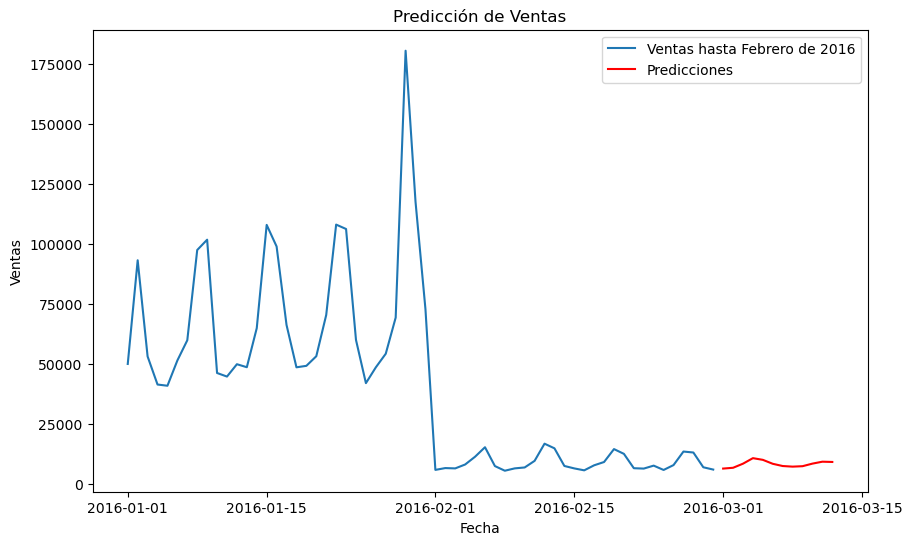

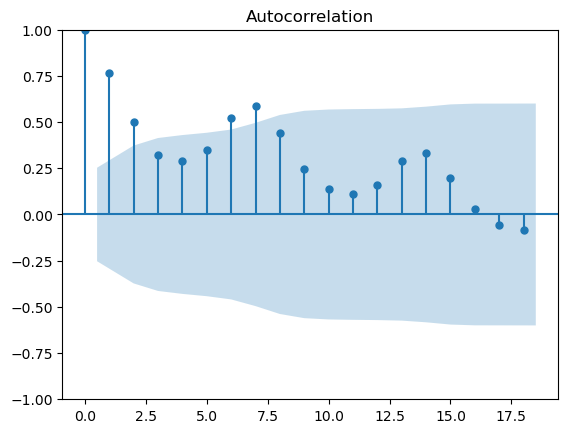

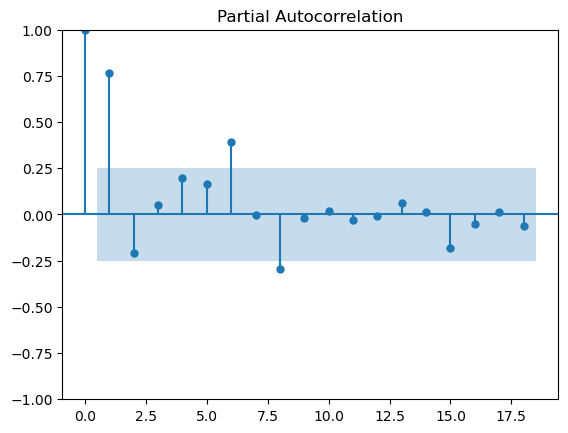

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Leer los datos de ventas desde un archivo Excel
ventas = pd.read_excel(r'C:\Codeproject\Analisis Inventario\VisualStudio_ETL\H_ventas.xlsx')

# Convertir la columna 'Fecha venta' a datetime con dayfirst=True
ventas['Fecha venta'] = pd.to_datetime(ventas['Fecha venta'], dayfirst=True)

# Preparar los datos de series temporales
ventas.set_index('Fecha venta', inplace=True)
# Convertir la columna 'Cantidad ventas' a tipo numérico
ventas_ts = ventas['Cantidad ventas'].resample('D').sum().astype(float)

# Entrenar modelo ARIMA
modelo = ARIMA(ventas_ts, order=(5,1,0))
modelo_entrenado = modelo.fit()

# Realizar predicciones
predicciones = modelo_entrenado.forecast(steps=12)

# Visualizar predicciones
plt.figure(figsize=(10, 6))
plt.plot(ventas_ts, label='Ventas hasta Febrero de 2016')
plt.plot(predicciones, color='red', label='Predicciones')
plt.title('Predicción de Ventas')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

# Autocorrelación y autocorrelación parcial
plot_acf(ventas_ts)
plot_pacf(ventas_ts)
plt.show()